<a href="https://colab.research.google.com/github/cocogne2/projet6/blob/master/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
from google.colab import drive 
from lxml import etree
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
drive.mount('/content/gdrive', force_remount=True)
path_to_data = os.path.join('gdrive','My Drive','projet_6')

Mounted at /content/gdrive


In [14]:
pip install livelossplot

In [ ]:
def cpu():
  %matplotlib inline
  path=os.path.join(path_to_data,'Images')
  for folder in os.listdir(path): 
      if os.path.isdir(os.path.join(path,folder)):
          print("folder",folder)
          path2=os.path.join(path,folder)
          race_chien=folder.split("-",1)[1]
          for file in os.listdir(path2):
            file=file.split(".")[0]
            nom_chien=file.split("_")[1]
            print("file:",file)
            tree = etree.parse(os.path.join(path_to_data,'Annotation', folder, file))
            for x in tree.xpath("/annotation/object/bndbox/xmin"):
                x_min=int(x.text)
            for x in tree.xpath("/annotation/object/bndbox/xmax"):
                x_max=int(x.text)
            for y in tree.xpath("/annotation/object/bndbox/ymin"):
                y_min=int(y.text)
            for y in tree.xpath("/annotation/object/bndbox/ymax"):
                y_max=int(y.text)
            
            # Import the image
            
            im = Image.open(os.path.join(path_to_data,'Images', folder, file+".jpg"))
            im=im.crop((x_min,y_min,x_max,y_max))             
            # Create a constant as filename
            file_save=race_chien+"*"+nom_chien

            file_name = os.path.join(path_to_data,'images_crop',file_save+".jpg")
            width, height = im.size
            if width>height:
              new_width=224
              size_index=new_width/width
              new_height=round(height*size_index)
            if width<=height:
              new_height=224
              size_index=new_height/height
              new_width=round(width*size_index)
            im=im.resize((new_width,new_height),Image.ANTIALIAS)
            new_im = Image.new("RGB", (224,224))
            new_im.paste(im, (round((224-new_width)/2),
                                round((224-new_height)/2)))
            new_im.save(file_name)
        
            #print("Image Saved!")
cpu()

In [36]:
# ---------------------------------------------------------------------------
# Configuration des paramètres principaux du modèle
# ---------------------------------------------------------------------------
# Le chemin vers la sauvegarde du réseau
model_savepath    = os.path.join(path_to_data,'cnn_vgg16_model_trained_sans_drop_2000_400.h5')     

# Les chemins vers les jeu de données
TRAINING_DIR      = os.path.join(path_to_data,'images_crop')
TESTING_DIR       = os.path.join(path_to_data,'test')

IMGSIZE       = 224    # Taille de l'image en input
EPOCH         = 100     # nombre d'epoch 
BATCH_SIZE    = 50     # traitement par batch d'images avant la descente de gradient
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

In [16]:
def list_unique(list_unique):
    """
    Cette fonction prend une liste en entrée et retourne la liste sans doublon
    """
    new_list = [] 
    for i in list_unique : 
        if i not in new_list: 
            new_list.append(i) 
    return new_list

In [18]:
# ---------------------------------------------------------------------------
#  Constitution des jeux de données
# ---------------------------------------------------------------------------    

# -------
#  Jeu d'entrainement
# -------

# Dataframe de deux colonnes contenant les id des fichiers et leur label
train_files = os.listdir(TRAINING_DIR)
train_labels = []

for file in train_files:
    train_labels.append(file.split("*",1)[0])
labels_sans_doublon=list_unique(train_labels)
df = pd.DataFrame({"id": train_files, "label": train_labels})
X=df["id"]
y=df["label"]
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25,stratify=y, random_state=1 ) # 25% des données dans le jeu de test
df_train =pd.DataFrame({"id": X_train, "label": y_train})
df_valid =pd.DataFrame({"id": X_test,  "label": y_test})

In [19]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
#from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
# Image generator: attention il est préférable de ne pas utiliser d'augmentation de données
# Nous utilisons également un processing spécifique au VGG16 et non pas un rescale 1./255
train_datagen =  \
        ImageDataGenerator(
            preprocessing_function=preprocess_input,
            validation_split=0)

train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='training',
            class_mode='categorical')
train_labels = to_categorical(train_generator.classes)

Found 15435 validated image filenames belonging to 120 classes.


In [21]:
# -------
#  Jeu de validation
# -------
valid_datagen =  \
        ImageDataGenerator(
            preprocessing_function=preprocess_input, validation_split=0.99999999)
        
valid_generator = \
        valid_datagen.flow_from_dataframe(
            df_valid,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='validation',
            class_mode='categorical')

Found 5144 validated image filenames belonging to 120 classes.


In [37]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------

# Déclaration du modèle VGG16 (sans le top qui est le classifier)

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMGSIZE, IMGSIZE, 3))
# Classifier
x = base_model.output
x = Flatten(name="flatten")(x)
#x = Dropout(0.5)(x)
x = Dense(2000,  name='top-fc1')(x)
x = Dense(400, name='top-fc2')(x)
#x = Dropout(0.5)(x)

# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(len(labels_sans_doublon),activation='softmax', name='softmax')(x)
# Assemblage du modèle final
net_final = Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False


# compilation du modele
net_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

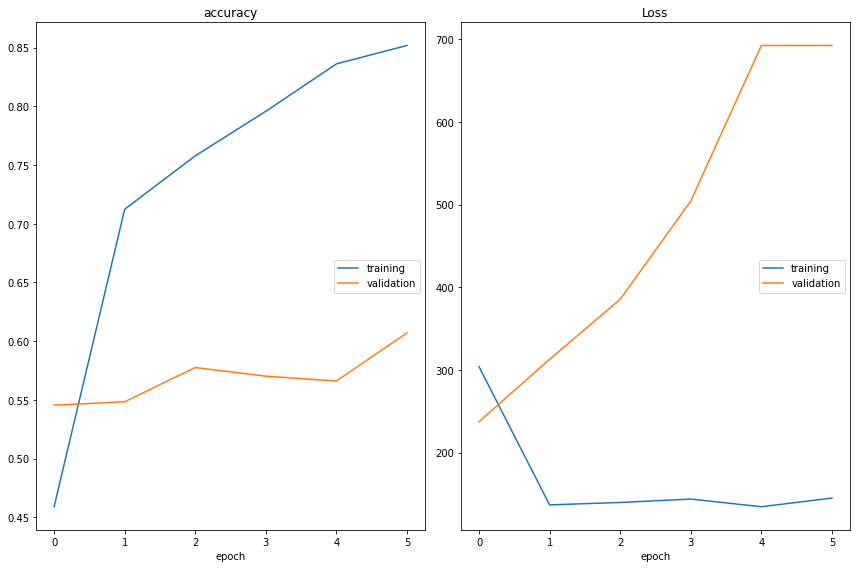

accuracy
	training         	 (min:    0.459, max:    0.852, cur:    0.852)
	validation       	 (min:    0.545, max:    0.607, cur:    0.607)
Loss
	training         	 (min:  134.656, max:  303.990, cur:  145.135)
	validation       	 (min:  237.351, max:  692.253, cur:  692.253)


In [38]:
from livelossplot.inputs.keras import PlotLossesCallback
if (TRAIN):
    plot_loss_1 = PlotLossesCallback()

    # Création des Callbacks à appeler aprés chaque epoch
    #   pour sauvegarde des résultats
    checkpoint = ModelCheckpoint("model_1.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
    #   pour arrêt prématuré
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
#   history = net_final.fit(train_generator,steps_per_epoch = STEP_SIZE_TRAIN, epochs=EPOCH, validation_data=valid_generator,validation_steps = STEP_SIZE_VALID,callbacks = [checkpoint, early, plot_loss_1])
    history = net_final.fit(train_generator, epochs=EPOCH, validation_data=valid_generator,batch_size=BATCH_SIZE,callbacks = [checkpoint, early, plot_loss_1])
    # Sauvegarde du réseau après entrainement
    net_final.save(model_savepath)    
    

In [ ]:
from tensorflow import keras
net_final = keras.models.load_model(model_savepath)

In [39]:
class_dict=train_generator.class_indices
labels= train_generator.labels
file=train_generator.filenames

new_dict={}
for key,value in class_dict.items():
        new_dict[value]=key 

valid2_generator = \
        valid_datagen.flow_from_dataframe(
            df_valid,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            shuffle=False,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='validation',
            class_mode='categorical')
pred = net_final.predict(valid2_generator, batch_size=BATCH_SIZE, verbose=0)
pred_labels = np.argmax(pred, axis=1)
true_labels=valid2_generator.labels
pred_classe=[]
x2=0
while x2<valid2_generator.n-1:
  pred_classe.append(new_dict[pred_labels[x2]])
  x2=x2+1


Found 5144 validated image filenames belonging to 120 classes.


In [40]:
mat_train=np.zeros((120,120))
i=0
while i<valid2_generator.n-1:
  il=0
  while il<20:
    ic=0
    while ic<20:
      if pred_labels[i]==il and true_labels[i]==ic:
        mat_train[il,ic]=mat_train[il,ic]+1
      ic=ic+1
    il=il+1
  i=i+1
print(mat_train)
np.savetxt(os.path.join(path_to_data,'mat_train_sans_drop_2000_400.csv'), mat_train, delimiter=',')

[[46.  0.  0. ...  0.  0.  0.]
 [ 0. 35.  0. ...  0.  0.  0.]
 [ 0.  0. 42. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


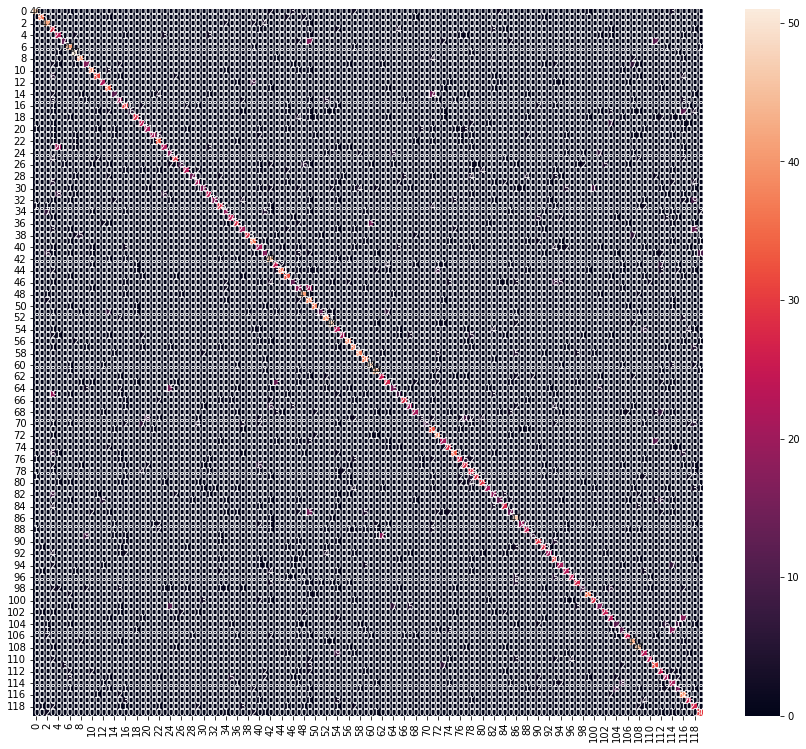

In [41]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def conf_matr(model,valid_dataset,valid_labels,dog_race_dict):
    '''
    Computes and plots the confusion matrix
    '''
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    array = confusion_matrix(valid_labels, valid_labels_pred)
    df_cm = pd.DataFrame(array, index = [i for i in dog_race_dict.keys()],
                      columns = [i for i in dog_race_dict.keys()])
    plt.figure(figsize = (15,13)).patch.set_facecolor('w')
    sn.heatmap(df_cm, annot=True)
conf_matr(net_final,valid2_generator,true_labels,dog_race_dict=new_dict)